In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ethos.constants import ADMISSION_STOKEN, DISCHARGE_STOKEN, ICU_ADMISSION_STOKEN, PROJECT_DATA, \
    ICU_DISCHARGE_STOKEN
from ethos.metrics import process_readmission_results, compute_gaussian_metrics, \
    process_admission_results

model_name = "mimic_layer_6_batch_32_do_0.3_best_test"

readmission_period = 30 / 365.25

In [3]:
mimic_derived = pd.read_csv(PROJECT_DATA / "mimic-iv_derived.csv.gz")
sepsis_df = mimic_derived.loc[mimic_derived.sepsis]
mimic_derived_patients = pd.read_csv(PROJECT_DATA / "mimic-iv_derived_patients.csv.gz")
ich_subjects = mimic_derived_patients.loc[mimic_derived_patients.ich].subject_id.unique()

In [5]:
df_inpatient_mort = process_admission_results(f"admission_mortality_{model_name}", DISCHARGE_STOKEN)

Dropped rows due to an ambiguous result: 2,342/866,180 (0.270%)


In [6]:
df_icu_mort = process_admission_results(f"icu_mortality_{model_name[:-5]}_no_time_offset_test",
                                        ICU_DISCHARGE_STOKEN)
df_sepsis_icu_mort = df_icu_mort.loc[df_icu_mort.stay_id.isin(sepsis_df.stay_id)]
df_icu_mort_los = df_icu_mort.loc[df_icu_mort.expected == 0]

Dropped rows due to an ambiguous result: 812/149,660 (0.543%)


In [7]:
import numpy as np

n_bootstrap = 1000
y_true = df_icu_mort_los.true_token_time * 365.25
y_pred = df_icu_mort_los.token_time * 365.25

np.random.seed(42)
errors = (y_true - y_pred).abs()
bootstrap_errors = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    sample_errors = np.random.choice(errors, size=len(errors), replace=True)
    bootstrap_errors[i] = np.mean(sample_errors)

lower_bound = np.percentile(bootstrap_errors, 2.5)
upper_bound = np.percentile(bootstrap_errors, 97.5)
print(f"MAE: {errors.mean():.3f}")
print(f"95% confidence interval: [{lower_bound:.3f}, {upper_bound:.3f}]")

MAE: 2.262
95% confidence interval: [2.161, 2.355]


In [8]:
df_icu_mort24 = process_admission_results(f"icu_mortality_{model_name}", ICU_DISCHARGE_STOKEN)
df_sepsis_icu_mort24 = df_icu_mort24.loc[df_icu_mort24.stay_id.isin(sepsis_df.stay_id)]

Dropped rows due to an ambiguous result: 700/118,000 (0.593%)


In [9]:
df_inpatient_readmission = process_readmission_results(f"readmission_{model_name}",
                                                       ADMISSION_STOKEN, readmission_period)

In [10]:
df_icu_readmission = process_readmission_results(f"icu_readmission_{model_name}",
                                                 ICU_ADMISSION_STOKEN, readmission_period)
df_ich_icu_readmission = df_icu_readmission.loc[df_icu_readmission.index.isin(ich_subjects)]

In [11]:
from matplotlib.offsetbox import AnchoredText

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 18

sns.set(context="paper", style="white")

plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['axes.labelcolor'] = black_color
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['text.color'] = black_color
plt.rcParams['xtick.color'] = black_color
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.color'] = black_color
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size


def compute_ci(y_true, y_proba, n_bootstraps=1000, seed=42) -> list:
    import numpy as np
    np.random.seed(seed)
    aucs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        y_true_boot = y_true.values[indices]
        y_proba_boot = y_proba.values[indices]
        res = compute_gaussian_metrics(y_true_boot, y_proba_boot)
        aucs.append(res["auc"])
        tprs.append(np.interp(mean_fpr, res["fpr_values"], res["tpr_values"]))
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensure ending at 1
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    return np.percentile(aucs, [2.5, 97.5]), mean_fpr, tprs_lower, tprs_upper


def plot_auc(y_true, y_proba, title="AUC-ROC"):
    res_fit = compute_gaussian_metrics(y_true, y_proba)

    (ci_lower, ci_upper), mean_fpr, tprs_lower, tprs_upper = compute_ci(y_true, y_proba)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=gray_color, alpha=0.4,
                     label="95% Confidence Interval")

    plt.scatter(res_fit["fpr_points"], res_fit["tpr_points"],
                marker="X", color=black_color, s=100,
                label="Unique Thresholds")
    plt.plot(
        res_fit["fpr_values"],
        res_fit["tpr_values"],
        color=orange_color,
        lw=5,
        label="Fitted ROC curve",
    )
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title(title)
    plt.grid(False)

    text = [
        f"Gaussian AUC: {res_fit['auc']:.3f}",
        f"N: {len(y_true):,} ({y_true.mean():.1%} positives)",
        f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]",
    ]
    at = AnchoredText(
        "\n".join(text),
        loc="lower right",
        frameon=False,
        prop=dict(size=font_size, color=black_color),
    )
    plt.gca().add_artist(at)

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

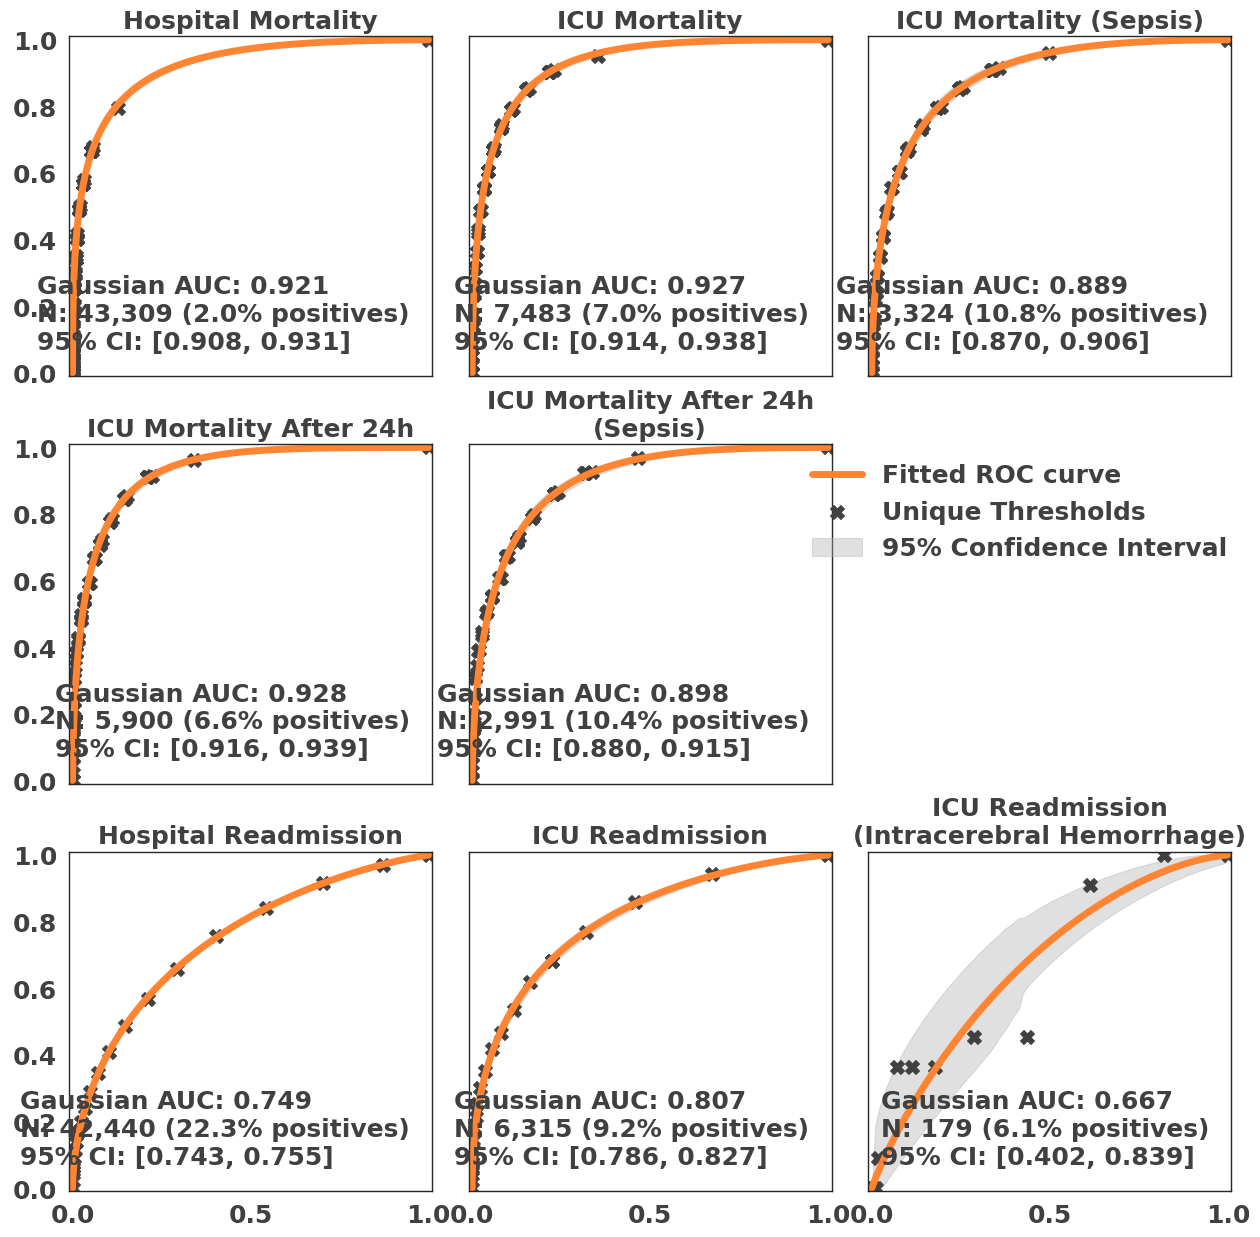

In [12]:
res = [
    ("Hospital Mortality", df_inpatient_mort),
    ("ICU Mortality", df_icu_mort),
    ("ICU Mortality (Sepsis)", df_sepsis_icu_mort),
    ("ICU Mortality After 24h", df_icu_mort24),
    ("ICU Mortality After 24h\n(Sepsis)", df_sepsis_icu_mort24),
    ("placeholder", ""),
    ("Hospital Readmission", df_inpatient_readmission),
    ("ICU Readmission", df_icu_readmission),
    ("ICU Readmission\n(Intracerebral Hemorrhage)", df_ich_icu_readmission),
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, (title, df) in enumerate(res):
    ax: plt.Axes = axes[i // 3, i % 3]
    plt.sca(ax)
    if i == 5:
        ax.set_visible(False)
        continue

    plot_auc(df.expected, df.actual, title=title)
    if i == 4:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="center right", frameon=False,
                  fontsize=font_size, bbox_to_anchor=(2.15, 0.8))
    if i % 3 != 0:
        ax.set_ylabel("")
        ax.set_yticks([])
    if i < 6:
        ax.set_xlabel("")
        ax.set_xticks([])

fig.subplots_adjust(wspace=0.1, hspace=0.2)